# Data

## season_game_level_data

In [209]:
import sys
import os
import pandas as pd
import numpy as np
import datetime, time
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pylab import hist, show
import scipy
import zipfile


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

**data frames used in this notebook:**
- da = pbp
- dg = season_games_data
- dm = play_by_play
- dp = player_rankings
- dw = team_roster_player_rank
- dv = season_team_roster_ranking
- dx = season_game_team_roster
- dz = season_team
- dy = season_game_roster

**for analysis:**
- ds = season_level
- dl = season_game_level
- dt = season_game_team_level

In [210]:
pwd

'/Users/stefanostselios/Desktop/nhl_roster_design-master'

### import play by play data set

In [211]:
da = pd.read_csv('pbp_merged.csv')
da = da.drop('Unnamed: 0', axis=1)
da = da.rename(columns={'TeamCode': 'EventTeamCode'})


keep regular season games

In [212]:
da = da[da['GameNumber'] <= 21230]

drop irrelevant data

In [213]:
da = da[da['EventType']!='STOP']
da = da[da['EventType']!='EISTR']
da = da[da['EventType']!='EIEND']

- display goals for each game and drop duplicates.

In [214]:
dh = da[da['EventTeamCode']==da['HTeamCode']]
dh = dh.rename(columns={'EventTeamCode': 'HTeam'})
dh['goal'] = dh.apply(lambda x: 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
dh['HGF'] = dh.groupby(['Season', 'GameNumber', 'HTeam'])['goal'].transform('sum')
dh = dh[['Season', 'GameNumber', 'HGF']]
dh = dh.drop_duplicates(['Season', 'GameNumber'])

In [215]:
dv = da[da['EventTeamCode']==da['VTeamCode']]
dv = dv.rename(columns={'EventTeamCode': 'VTeam'})
dv['goal'] = dv.apply(lambda x: 1 if (x['EventType'] == 'GOAL') else 0, axis=1)
dv['VGF'] = dv.groupby(['Season', 'GameNumber', 'VTeam'])['goal'].transform('sum')
dv = dv[['Season', 'GameNumber', 'VGF']]
dv = dv.drop_duplicates(['Season', 'GameNumber'])

Merge into season-game data

In [216]:
# dg = dp[['Season', 'GameNumber', 'EventTeamCode', 'VTeamCode', 'HTeamCode']]
# dg = dg.drop_duplicates(['Season', 'GameNumber',  'EventTeamCode'])
# dg = dg.rename(columns={'EventTeamCode': 'Team'})
# dg['Opp'] = dg.apply(lambda x: x['HTeamCode'] if x['Team'] == x['HTeamCode'] else x['VTeamCode'], axis=1)
# dg['Designation'] = dg.apply(lambda x: 'home' if x['Team'] == x['HTeamCode'] else 'away', axis=1)
# dg = dg[['Season', 'GameNumber', 'Team', 'Opp', 'Designation']]

In [217]:
dg = da[['Season', 'GameNumber', 'VTeamCode', 'HTeamCode']]
dg = dg.drop_duplicates(['Season', 'GameNumber'])

In [218]:
dg = pd.merge(dg, dh, on=['Season', 'GameNumber'], how='left')
dg = pd.merge(dg, dv, on=['Season', 'GameNumber'], how='left')

- find the goal differential per game with respect to home team.

In [219]:
dg['GD'] = dg['HGF'] - dg['VGF']
dg['WinTeam'] = dg.apply(lambda x: x['HTeamCode'] if x['GD'] > 0 else x['VTeamCode'], axis=1)
dg['LossTeam'] = dg.apply(lambda x: x['HTeamCode'] if x['WinTeam'] != x['HTeamCode'] else x['VTeamCode'], axis=1)

In [220]:
dg.head()

,Season,GameNumber,VTeamCode,HTeamCode,HGF,VGF,GD,WinTeam,LossTeam
0,2010,20001,MTL,TOR,3,2,1,TOR,MTL
1,2010,20002,PHI,PIT,2,3,-1,PHI,PIT
2,2010,20003,CAR,MIN,3,4,-1,CAR,MIN
3,2010,20004,CHI,COL,4,3,1,COL,CHI
4,2010,20005,CGY,EDM,4,0,4,EDM,CGY


- display goals againest per team.

In [221]:
dg['VGA'] = dg['HGF']
dg['HGA'] = dg['VGF']

In [222]:
dg = dg[['Season', 'GameNumber', 'VTeamCode', 'HTeamCode', 'VGF', 'HGF', 'GD', 'VGA', 'HGA', 'WinTeam', 'LossTeam']]
dg.head()

,Season,GameNumber,VTeamCode,HTeamCode,VGF,HGF,GD,VGA,HGA,WinTeam,LossTeam
0,2010,20001,MTL,TOR,2,3,1,3,2,TOR,MTL
1,2010,20002,PHI,PIT,3,2,-1,2,3,PHI,PIT
2,2010,20003,CAR,MIN,4,3,-1,3,4,CAR,MIN
3,2010,20004,CHI,COL,3,4,1,4,3,COL,CHI
4,2010,20005,CGY,EDM,0,4,4,4,0,EDM,CGY


In [223]:
dg.to_csv('season_game_data.csv', index='False')

## season_level_data

In [224]:
dm = da

events that happened in regulation time only

In [225]:
dm = dm[dm['Period'] <= 3]
dm = dm[dm['Period'] >= 1]

- **reshape the data set from wide to long.**

In [226]:
dm = dm.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

In [227]:
a = [col for col in dm.columns if 'VPlayer' in col]
b = [col for col in dm.columns if 'HPlayer' in col]
c = [col for col in dm.columns if 'VPosition' in col]
d = [col for col in dm.columns if 'HPosition' in col]
dm = pd.lreshape(dm, {'VPlayer' : a, 'HPlayer' : b, 'VPosition' : c, 'HPosition': d})

In [228]:
dm.shape

(1796745, 24)

In [229]:
dm.columns

Index(['AdvantageType', 'EventDetail', 'EventNumber', 'EventTeamCode',
       'EventTimeFromTwenty', 'EventTimeFromZero', 'EventType', 'GameDate',
       'GameNumber', 'HTeamCode', 'Length', 'PenaltyType', 'Period',
       'PlayerName', 'PlayerNumber', 'Season', 'ShotResult', 'ShotType',
       'VTeamCode', 'Zone', 'VPlayer', 'HPlayer', 'VPosition', 'HPosition'],
      dtype='object')

In [230]:
dm = dm.rename(columns={'PlayerNumber': 'EventPlayerNumber', 'TeamCode': 'EventTeamCode', 'PlayerName': 'EventPlayerName' })
dm = dm[['Season', 'GameNumber', 'GameDate', 'Period', 'AdvantageType', 'Zone', 'EventNumber', 'EventType', 'EventDetail', 'EventTeamCode', 'EventPlayerNumber', 'EventPlayerName', 'EventTimeFromZero', 'EventTimeFromTwenty', 'VTeamCode', 'VPlayer', 'VPosition', 'HTeamCode', 'HPlayer', 'HPosition', 'ShotType', 'ShotResult', 'Length', 'PenaltyType']]
dm = dm.sort_values(['Season', 'GameNumber', 'Period', 'EventNumber'], ascending=[True, True, True, True])

- fill in advantage type with even strength 'EV' and event player number with 'TEAM'

In [231]:
dm['AdvantageType'] = dm['AdvantageType'].fillna('EV')
dm['EventPlayerNumber'] = dm['EventPlayerNumber'].fillna('TEAM')

- save new datast as play by play

In [232]:
dm.to_csv('play_by_play.csv', index='False', sep=',')

#### create new data set and keep variables: 
- (a) game number.
- (b) visitor team information.
- (c) home team information.

In [233]:
df = dm[['Season', 'GameNumber', 'VTeamCode', 'VPlayer', 'VPosition', 'HTeamCode', 'HPlayer', 'HPosition']]
df = df.sort_values(['Season', 'GameNumber'], ascending=[True, True])
df.head()

,Season,GameNumber,VTeamCode,VPlayer,VPosition,HTeamCode,HPlayer,HPosition
0,2010,20001,MTL,11.0,C,TOR,37.0,C
310113,2010,20001,MTL,21.0,R,TOR,9.0,R
620126,2010,20001,MTL,57.0,L,TOR,11.0,L
930061,2010,20001,MTL,26.0,D,TOR,3.0,D
1239931,2010,20001,MTL,75.0,D,TOR,22.0,D


- merge season_game_data (dg) on new dataset

In [234]:
df = pd.merge(df, dg, on=['Season', 'GameNumber', 'VTeamCode', 'HTeamCode'], how='left')
df.head()    

,Season,GameNumber,VTeamCode,VPlayer,VPosition,HTeamCode,HPlayer,HPosition,VGF,HGF,GD,VGA,HGA,WinTeam,LossTeam
0,2010,20001,MTL,11.0,C,TOR,37.0,C,2,3,1,3,2,TOR,MTL
1,2010,20001,MTL,21.0,R,TOR,9.0,R,2,3,1,3,2,TOR,MTL
2,2010,20001,MTL,57.0,L,TOR,11.0,L,2,3,1,3,2,TOR,MTL
3,2010,20001,MTL,26.0,D,TOR,3.0,D,2,3,1,3,2,TOR,MTL
4,2010,20001,MTL,75.0,D,TOR,22.0,D,2,3,1,3,2,TOR,MTL


- reshape the data to have home and visitor team observatons under the same coloumns. 

In [235]:
a = [col for col in df.columns if 'Player' in col]
b = [col for col in df.columns if 'Position' in col]
c = [col for col in df.columns if 'TeamCode' in col]
d = [col for col in df.columns if 'GF' in col]
e = [col for col in df.columns if 'GA' in col]
df = pd.lreshape(df, {'PlayerNumber' : a, 'PlayerPosition' : b, 'TeamCode' : c, 'GF' : d, 'GA' : e })
df.head()

,GD,GameNumber,LossTeam,Season,WinTeam,PlayerNumber,PlayerPosition,TeamCode,GF,GA
0,1,20001,MTL,2010,TOR,11.0,C,MTL,2,3
1,1,20001,MTL,2010,TOR,21.0,R,MTL,2,3
2,1,20001,MTL,2010,TOR,57.0,L,MTL,2,3
3,1,20001,MTL,2010,TOR,26.0,D,MTL,2,3
4,1,20001,MTL,2010,TOR,75.0,D,MTL,2,3


- import player rankings

In [236]:
dp = pd.read_csv('player_rank_manual.csv')
dp = dp.drop('Unnamed: 0', axis=1)

- **display each player by team per game. Drop duplicates.**

In [237]:
dw = pd.merge(df, dp, on=['Season', 'TeamCode', 'PlayerNumber', 'PlayerPosition'], how='left')

- create column that displays the position and roster count by team per game. 

In [238]:
dw = dw[dw.PlayerPosition!='G']
dw = dw.drop_duplicates(['Season', 'GameNumber', 'TeamCode', 'PlayerNumber'])
dw['RosterCount'] = dw.groupby(['Season', 'GameNumber', 'TeamCode'])['PlayerNumber'].transform('count')
dw['Position'] = dw.apply(lambda x: 'D' if x['PlayerPosition']=='D' else 'F', 1)
dw['PositionCount'] = dw.groupby(['Season', 'GameNumber', 'TeamCode', 'Position'])['PlayerNumber'].transform('count')
dw.head()

,GD,GameNumber,LossTeam,Season,WinTeam,PlayerNumber,PlayerPosition,TeamCode,GF,GA,Rank,RosterCount,Position,PositionCount
0,1,20001,MTL,2010,TOR,11.0,C,MTL,2,3,2,18.0,F,12.0
1,1,20001,MTL,2010,TOR,21.0,R,MTL,2,3,1,18.0,F,12.0
2,1,20001,MTL,2010,TOR,57.0,L,MTL,2,3,2,18.0,F,12.0
3,1,20001,MTL,2010,TOR,26.0,D,MTL,2,3,2,18.0,D,6.0
4,1,20001,MTL,2010,TOR,75.0,D,MTL,2,3,2,18.0,D,6.0


- count the amount of forwards and defensemen by team per game.

In [239]:
dw['FCount'] = dw.apply(lambda x: x['PositionCount'] if x['Position']=='F' else np.NaN, 1)
dw['DCount'] = dw.apply(lambda x: x['PositionCount'] if x['Position']=='D' else np.NaN, 1)
dw['FCount'] = dw.groupby(['Season','GameNumber', 'TeamCode'])['FCount'].apply(lambda x: x.ffill().bfill())
dw['DCount'] = dw.groupby(['Season','GameNumber', 'TeamCode'])['DCount'].apply(lambda x: x.ffill().bfill())
dw.head()

,GD,GameNumber,LossTeam,Season,WinTeam,PlayerNumber,PlayerPosition,TeamCode,GF,GA,Rank,RosterCount,Position,PositionCount,FCount,DCount
0,1,20001,MTL,2010,TOR,11.0,C,MTL,2,3,2,18.0,F,12.0,12.0,6.0
1,1,20001,MTL,2010,TOR,21.0,R,MTL,2,3,1,18.0,F,12.0,12.0,6.0
2,1,20001,MTL,2010,TOR,57.0,L,MTL,2,3,2,18.0,F,12.0,12.0,6.0
3,1,20001,MTL,2010,TOR,26.0,D,MTL,2,3,2,18.0,D,6.0,12.0,6.0
4,1,20001,MTL,2010,TOR,75.0,D,MTL,2,3,2,18.0,D,6.0,12.0,6.0


### keep games that have only 12 F and 6 D per team!!!!

In [240]:
dw = dw.groupby(['Season', 'GameNumber']).filter(lambda x: ((x['FCount'] == 12) & (x['DCount'] == 6)).all())

In [241]:
dw.shape

(36540, 16)

In [242]:
dw.to_csv('team_roster_player_rank.csv', index='False')

- create a new dataset using team roster player rank

In [243]:
dv = dw

In [244]:
dv = dv.groupby(['Season', 'GameNumber', 'TeamCode', 'Position', 'GF', 'GA', 'RosterCount', 'PositionCount', 'FCount', 'DCount', 'WinTeam', 'LossTeam'], as_index=False)['Rank'].mean()
dv.head(10)

,Season,GameNumber,TeamCode,Position,GF,GA,RosterCount,PositionCount,FCount,DCount,WinTeam,LossTeam,Rank
0,2010,20001,MTL,D,2,3,18.0,6.0,12.0,6.0,TOR,MTL,1.833333
1,2010,20001,MTL,F,2,3,18.0,12.0,12.0,6.0,TOR,MTL,1.833333
2,2010,20001,TOR,D,3,2,18.0,6.0,12.0,6.0,TOR,MTL,1.833333
3,2010,20001,TOR,F,3,2,18.0,12.0,12.0,6.0,TOR,MTL,1.833333
4,2010,20002,PHI,D,3,2,18.0,6.0,12.0,6.0,PHI,PIT,1.666667
5,2010,20002,PHI,F,3,2,18.0,12.0,12.0,6.0,PHI,PIT,1.583333
6,2010,20002,PIT,D,2,3,18.0,6.0,12.0,6.0,PHI,PIT,1.500000
7,2010,20002,PIT,F,2,3,18.0,12.0,12.0,6.0,PHI,PIT,1.583333
8,2010,20003,CAR,D,4,3,18.0,6.0,12.0,6.0,CAR,MIN,1.833333
9,2010,20003,CAR,F,4,3,18.0,12.0,12.0,6.0,CAR,MIN,1.750000


In [245]:
dv.shape

(4060, 13)

- create columns for team win and team loss. 

In [246]:
dv['TeamWin'] =  dv.apply(lambda x: 1 if x['TeamCode']==x['WinTeam'] else 0, 1)
dv['TeamLos'] =  dv.apply(lambda x: 1 if x['TeamCode']!=x['WinTeam'] else 0, 1)
dv.head()

,Season,GameNumber,TeamCode,Position,GF,GA,RosterCount,PositionCount,FCount,DCount,WinTeam,LossTeam,Rank,TeamWin,TeamLos
0,2010,20001,MTL,D,2,3,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,0,1
1,2010,20001,MTL,F,2,3,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,0,1
2,2010,20001,TOR,D,3,2,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,1,0
3,2010,20001,TOR,F,3,2,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,1,0
4,2010,20002,PHI,D,3,2,18.0,6.0,12.0,6.0,PHI,PIT,1.666667,1,0


- display games played, games won, games loss, goals for and goals against by team for the season.

In [247]:
dv['GP'] = dv.groupby(['Season', 'Position', 'TeamCode'])['GameNumber'].transform('count')
dv['GW'] = dv.groupby(['Season', 'Position', 'WinTeam'])['TeamWin'].transform('sum')
dv['GL'] = dv.groupby(['Season', 'Position', 'LossTeam'])['TeamLos'].transform('sum')
dv['GF'] = dv.groupby(['Season', 'Position', 'TeamCode'])['GF'].transform('sum')
dv['GA'] = dv.groupby(['Season', 'Position', 'TeamCode'])['GA'].transform('sum')
dv.head()

,Season,GameNumber,TeamCode,Position,GF,GA,RosterCount,PositionCount,FCount,DCount,WinTeam,LossTeam,Rank,TeamWin,TeamLos,GP,GW,GL
0,2010,20001,MTL,D,188,181,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31
1,2010,20001,MTL,F,188,181,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31
2,2010,20001,TOR,D,195,218,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31
3,2010,20001,TOR,F,195,218,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31
4,2010,20002,PHI,D,235,207,18.0,6.0,12.0,6.0,PHI,PIT,1.666667,1,0,72,41,31


- create columns with the mean ranking for forward and defenseman by team per game.

In [248]:
dv['Rank_F'] = dv.apply(lambda x: x['Rank'] if x['Position']=='F' else np.NaN, 1)
dv['Rank_D'] = dv.apply(lambda x: x['Rank'] if x['Position']=='D' else np.NaN, 1)
dv['Rank_F'] = dv.groupby(['Season','GameNumber', 'TeamCode'])['Rank_F'].apply(lambda x: x.ffill().bfill())
dv['Rank_D'] = dv.groupby(['Season','GameNumber', 'TeamCode'])['Rank_D'].apply(lambda x: x.ffill().bfill())
dv.head()

,Season,GameNumber,TeamCode,Position,GF,GA,RosterCount,PositionCount,FCount,DCount,WinTeam,LossTeam,Rank,TeamWin,TeamLos,GP,GW,GL,Rank_F,Rank_D
0,2010,20001,MTL,D,188,181,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31,1.833333,1.833333
1,2010,20001,MTL,F,188,181,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31,1.833333,1.833333
2,2010,20001,TOR,D,195,218,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31,1.833333,1.833333
3,2010,20001,TOR,F,195,218,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31,1.833333,1.833333
4,2010,20002,PHI,D,235,207,18.0,6.0,12.0,6.0,PHI,PIT,1.666667,1,0,72,41,31,1.583333,1.666667


- compute the mean per position by team for the season.

In [249]:
dv['Mean_F']= dv.groupby(['Season', 'TeamCode'])['Rank_F'].transform('mean')
dv['Mean_D']= dv.groupby(['Season', 'TeamCode'])['Rank_D'].transform('mean')
dv.head()

,Season,GameNumber,TeamCode,Position,GF,GA,RosterCount,PositionCount,FCount,DCount,WinTeam,LossTeam,Rank,TeamWin,TeamLos,GP,GW,GL,Rank_F,Rank_D,Mean_F,Mean_D
0,2010,20001,MTL,D,188,181,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31,1.833333,1.833333,1.734069,1.825980
1,2010,20001,MTL,F,188,181,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31,1.833333,1.833333,1.734069,1.825980
2,2010,20001,TOR,D,195,218,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31,1.833333,1.833333,1.834524,1.888095
3,2010,20001,TOR,F,195,218,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31,1.833333,1.833333,1.834524,1.888095
4,2010,20002,PHI,D,235,207,18.0,6.0,12.0,6.0,PHI,PIT,1.666667,1,0,72,41,31,1.583333,1.666667,1.592593,1.571759


- display the quantity of wins and losses per team ( roster of 12 forwards and 6 defensemen)

In [250]:
dv['L'] = dv.apply(lambda x: x['GL'] if x['TeamCode']== x['LossTeam'] else (x['GP'] - x['GW']), 1)
dv['W'] = dv.apply(lambda x: x['GW'] if x['TeamCode']== x['WinTeam'] else (x['GP'] - x['GL']), 1)
dv.head()

,Season,GameNumber,TeamCode,Position,GF,GA,RosterCount,PositionCount,FCount,DCount,WinTeam,LossTeam,Rank,TeamWin,TeamLos,GP,GW,GL,Rank_F,Rank_D,Mean_F,Mean_D,L,W
0,2010,20001,MTL,D,188,181,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31,1.833333,1.833333,1.734069,1.825980,31,37
1,2010,20001,MTL,F,188,181,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,0,1,68,34,31,1.833333,1.833333,1.734069,1.825980,31,37
2,2010,20001,TOR,D,195,218,18.0,6.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31,1.833333,1.833333,1.834524,1.888095,36,34
3,2010,20001,TOR,F,195,218,18.0,12.0,12.0,6.0,TOR,MTL,1.833333,1,0,70,34,31,1.833333,1.833333,1.834524,1.888095,36,34
4,2010,20002,PHI,D,235,207,18.0,6.0,12.0,6.0,PHI,PIT,1.666667,1,0,72,41,31,1.583333,1.666667,1.592593,1.571759,31,41


- compute win and loss percent by team. Drop duplicate observations.

In [251]:
dv = dv[['Season', 'TeamCode', 'GP', 'L', 'W', 'GF', 'GA', 'Mean_F', 'Mean_D']]
dv = dv.drop_duplicates(['Season', 'TeamCode'])
dv['WinPc'] = dv['W']/ dv['GP']
dv['LossPc'] = dv['L']/ dv['GP']

dv = dv[['Season', 'TeamCode', 'GP','W', 'L', 'GF', 'GA', 'WinPc', 'LossPc', 'Mean_F', 'Mean_D']]
dv.head()

,Season,TeamCode,GP,W,L,GF,GA,WinPc,LossPc,Mean_F,Mean_D
0,2010,MTL,68,37,31,188,181,0.544118,0.455882,1.734069,1.825980
2,2010,TOR,70,34,36,195,218,0.485714,0.514286,1.834524,1.888095
4,2010,PHI,72,41,31,235,207,0.569444,0.430556,1.592593,1.571759
6,2010,PIT,71,40,31,204,180,0.563380,0.436620,1.642019,1.561033
8,2010,CAR,76,38,38,222,218,0.500000,0.500000,1.751096,1.804825


- rank teams based on win percent, mean forwards and mean defensemen. 

In [252]:
dv['Rank_W'] = dv.groupby(['Season'])['WinPc'].rank(ascending=False)
dv['Rank_F'] = dv.groupby(['Season'])['Mean_F'].rank(ascending=True)
dv['Rank_D'] = dv.groupby(['Season'])['Mean_D'].rank(ascending=True)
dv = dv.sort_values(['Season', 'Rank_W', 'Rank_F', 'Rank_D'], ascending=[True, True, True, True])
dv.head(30)

,Season,TeamCode,GP,W,L,GF,GA,WinPc,LossPc,Mean_F,Mean_D,Rank_W,Rank_F,Rank_D
70,2010,VAN,73,48,25,238,175,0.657534,0.342466,1.602740,1.600457,1.0,4.0,8.0
22,2010,SJ,65,41,24,206,158,0.630769,0.369231,1.519231,1.535897,2.0,1.0,2.0
36,2010,BOS,76,45,31,228,176,0.592105,0.407895,1.603070,1.530702,3.0,5.0,1.0
30,2010,DET,68,40,28,220,201,0.588235,0.411765,1.636029,1.546569,4.0,8.0,3.0
28,2010,ANA,65,38,27,186,181,0.584615,0.415385,1.608974,1.648718,5.0,6.0,9.0
102,2010,WSH,72,42,30,190,169,0.583333,0.416667,1.613426,1.571759,6.0,7.0,6.0
68,2010,LA,70,40,30,194,178,0.571429,0.428571,1.602381,1.559524,7.0,3.0,4.0
4,2010,PHI,72,41,31,235,207,0.569444,0.430556,1.592593,1.571759,8.0,2.0,7.0
6,2010,PIT,71,40,31,204,180,0.563380,0.436620,1.642019,1.561033,9.0,9.0,5.0
42,2010,NYR,73,41,32,223,177,0.561644,0.438356,1.712329,1.680365,10.0,13.0,12.0


In [253]:
dv.shape

(30, 14)

In [254]:
dv.to_csv('season_team_roster_ranking.csv', index='False')

## season_game_team_roster_data

- use the team roster player rank dataset (dw) to display the roster quality by team per game

In [255]:
dx = dw

In [256]:
dx = dx[['Season', 'GameNumber', 'TeamCode', 'RosterCount', 'PlayerNumber', 'Position', 'Rank']]
dx.head()

,Season,GameNumber,TeamCode,RosterCount,PlayerNumber,Position,Rank
0,2010,20001,MTL,18.0,11.0,F,2
1,2010,20001,MTL,18.0,21.0,F,1
2,2010,20001,MTL,18.0,57.0,F,2
3,2010,20001,MTL,18.0,26.0,D,2
4,2010,20001,MTL,18.0,75.0,D,2


- group by season, game number, team and player to count the occurance of each player per game and sum up the observations of players. There should be 19 players per team and 38 per game for the dataset to be correct.

In [257]:
dx['playercount'] = dx.groupby(['Season', 'GameNumber', 'TeamCode', 'PlayerNumber',])['PlayerNumber'].transform('count')

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [258]:
dx['rosterposition'] = dx.groupby(['Season', 'GameNumber', 'TeamCode', 'Position', 'Rank'])['playercount'].transform('sum')

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### pivot table

- the next step is to group players by gamenumber, teamcode, position and rank, to display the quality of players each team has per position. **Pivot table** by player position and rank using roster position values. Game number and team are the indexes. We want to join the levels to generate columns by roster position and rank (10 columns). 


In [259]:
dx = pd.pivot_table(dx, index=['Season', 'GameNumber', 'TeamCode', 'RosterCount'], columns=['Position', 'Rank'], values=['rosterposition'])
dx = dx.reset_index()
dx.columns = ['_'.join(str(s).strip() for s in col if s) for col in dx.columns]
dx.reset_index()
dx = dx.fillna(0)
dx = dx.rename(columns={'rosterposition_F_1': 'F1', 'rosterposition_F_2': 'F2', 'rosterposition_D_1': 'D1', 'rosterposition_D_2': 'D2'})
dx.head(10)

,Season,GameNumber,TeamCode,RosterCount,D1,D2,F1,F2
0,2010,20001,MTL,18.0,1.0,5.0,2.0,10.0
1,2010,20001,TOR,18.0,1.0,5.0,2.0,10.0
2,2010,20002,PHI,18.0,2.0,4.0,5.0,7.0
3,2010,20002,PIT,18.0,3.0,3.0,5.0,7.0
4,2010,20003,CAR,18.0,1.0,5.0,3.0,9.0
5,2010,20003,MIN,18.0,1.0,5.0,2.0,10.0
6,2010,20004,CHI,18.0,2.0,4.0,4.0,8.0
7,2010,20004,COL,18.0,1.0,5.0,2.0,10.0
8,2010,20005,CGY,18.0,1.0,5.0,3.0,9.0
9,2010,20005,EDM,18.0,1.0,5.0,0.0,12.0


In [260]:
dx.shape

(2030, 8)

In [261]:
dx.to_csv('season_game_team_roster.csv', index='False', sep=',')

- create a dataset that will display the mean of forwards and defencemen by season per team

In [262]:
dz = dx

In [263]:
dz['MeanF1'] = dz.groupby(['Season', 'TeamCode'])['F1'].transform('mean')
dz['MeanF2'] = dz.groupby(['Season', 'TeamCode'])['F2'].transform('mean')
dz['MeanD1'] = dz.groupby(['Season', 'TeamCode'])['D1'].transform('mean')
dz['MeanD2'] = dz.groupby(['Season', 'TeamCode'])['D2'].transform('mean')
dz.head()

,Season,GameNumber,TeamCode,RosterCount,D1,D2,F1,F2,MeanF1,MeanF2,MeanD1,MeanD2
0,2010,20001,MTL,18.0,1.0,5.0,2.0,10.0,3.191176,8.808824,1.044118,4.955882
1,2010,20001,TOR,18.0,1.0,5.0,2.0,10.0,1.985714,10.014286,0.671429,5.328571
2,2010,20002,PHI,18.0,2.0,4.0,5.0,7.0,4.888889,7.111111,2.569444,3.430556
3,2010,20002,PIT,18.0,3.0,3.0,5.0,7.0,4.295775,7.704225,2.633803,3.366197
4,2010,20003,CAR,18.0,1.0,5.0,3.0,9.0,2.986842,9.013158,1.171053,4.828947


- drop duplicates by season and team

In [264]:
dz = dz.drop_duplicates(['Season', 'TeamCode'])

In [265]:
dz = dz[['Season', 'TeamCode', 'RosterCount', 'MeanF1', 'MeanF2', 'MeanD1', 'MeanD2']]
dz.head()

,Season,TeamCode,RosterCount,MeanF1,MeanF2,MeanD1,MeanD2
0,2010,MTL,18.0,3.191176,8.808824,1.044118,4.955882
1,2010,TOR,18.0,1.985714,10.014286,0.671429,5.328571
2,2010,PHI,18.0,4.888889,7.111111,2.569444,3.430556
3,2010,PIT,18.0,4.295775,7.704225,2.633803,3.366197
4,2010,CAR,18.0,2.986842,9.013158,1.171053,4.828947


In [266]:
dz.shape

(30, 7)

In [267]:
dz.to_csv('season_team.csv', index='False', sep=',')

- create an index variable to deterime if a team is considered visitor or home for a given game. The column will be named "A". The 1st observation per game is the visitor team and will be assigned a value of 1. The 2nd and final observation per game, is the home team, so we fill in NaN with a value of 2 (home team)

In [268]:
dy = dx

In [269]:
dy.loc[dy.groupby('GameNumber',as_index=False).head(1).index,'A'] = 1
dy = dy.fillna(2)

- **pivot table using game number as index by whether a team is visitor (1) or home (2)**. The table will display the quality of each player per position and team. The next step is to join columns by team and player quality value. We will have for each team 10 columns ( 5 positions x 2 type of player quality). We will rename the columns as following: VC1 shows the amount of elite centers for the visitor team, HC1 displays the amount of elite centers for the home team etc. We rename the columns and sort them based on team, position and quality. 

In [270]:
dy = pd.pivot_table(dy, index=['Season', 'GameNumber'], columns=['A'], values=['F1', 'F2', 'D1', 'D2'])
dy = dy.reset_index()
dy.columns = ['_'.join(str(s).strip() for s in col if s) for col in dy.columns]
dy = dy.reset_index()
dy = dy.rename(columns={'F1_1.0': 'VF1', 'F2_1.0': 'VF2', 'D1_1.0': 'VD1', 'D2_1.0': 'VD2', 'F1_2.0': 'HF1', 'F2_2.0': 'HF2', 'D1_2.0': 'HD1', 'D2_2.0': 'HD2'})
dy = dy[['Season', 'GameNumber', 'VF1', 'VF2', 'VD1', 'VD2', 'HF1', 'HF2', 'HD1', 'HD2']]
dy.sort_values(['Season', 'GameNumber'], ascending=[True, True], inplace=True)
dy.head()

,Season,GameNumber,VF1,VF2,VD1,VD2,HF1,HF2,HD1,HD2
0,2010,20001,2.0,10.0,1.0,5.0,2.0,10.0,1.0,5.0
1,2010,20002,5.0,7.0,2.0,4.0,5.0,7.0,3.0,3.0
2,2010,20003,3.0,9.0,1.0,5.0,2.0,10.0,1.0,5.0
3,2010,20004,4.0,8.0,2.0,4.0,2.0,10.0,1.0,5.0
4,2010,20005,3.0,9.0,1.0,5.0,0.0,12.0,1.0,5.0


In [271]:
dy.shape

(1015, 10)

In [272]:
dy.to_csv('season_game_roster.csv', index='False', sep=',')

# Roster Analysis

## season_level_analysis

- merge season_team dataset (dz) and season_team_roster_ranking (dv) for roster analysis at the season level. Use **ds** as the merging dataset.

In [273]:
ds = dv.merge(dz, on=['Season', 'TeamCode'], how='left')
ds.head()

,Season,TeamCode,GP,W,L,GF,GA,WinPc,LossPc,Mean_F,Mean_D,Rank_W,Rank_F,Rank_D,RosterCount,MeanF1,MeanF2,MeanD1,MeanD2
0,2010,VAN,73,48,25,238,175,0.657534,0.342466,1.602740,1.600457,1.0,4.0,8.0,18.0,4.767123,7.232877,2.397260,3.602740
1,2010,SJ,65,41,24,206,158,0.630769,0.369231,1.519231,1.535897,2.0,1.0,2.0,18.0,5.769231,6.230769,2.784615,3.215385
2,2010,BOS,76,45,31,228,176,0.592105,0.407895,1.603070,1.530702,3.0,5.0,1.0,18.0,4.763158,7.236842,2.815789,3.184211
3,2010,DET,68,40,28,220,201,0.588235,0.411765,1.636029,1.546569,4.0,8.0,3.0,18.0,4.367647,7.632353,2.720588,3.279412
4,2010,ANA,65,38,27,186,181,0.584615,0.415385,1.608974,1.648718,5.0,6.0,9.0,18.0,4.692308,7.307692,2.107692,3.892308


- display the diffence in quality of forwards (DF) and defensemen (DD) per team.

In [274]:
ds['DF'] = ds['MeanF1'] - ds['MeanF2']
ds['DD'] = ds['MeanD1'] - ds['MeanD2']

- mean goals for and mean goals against per team.

In [275]:
ds['meanGF'] = ds['GF']/ ds['GP']
ds['meanGA'] = ds['GA']/ ds['GP']

In [276]:
ds.shape

(30, 23)

### summary analysis

In [277]:
ds.describe()

,Season,GP,W,L,GF,GA,WinPc,LossPc,Mean_F,Mean_D,Rank_W,Rank_F,Rank_D,RosterCount,MeanF1,MeanF2,MeanD1,MeanD2,DF,DD,meanGF,meanGA
count,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2010.0,67.666667,33.833333,33.833333,192.233333,192.233333,0.498496,0.501504,1.747567,1.752933,15.500000,15.500000,15.500000,18.0,3.029195,8.970805,1.482401,4.517599,-5.941610,-3.035198,2.843540,2.856977
std,0.0,8.052985,7.991734,7.240134,29.395852,27.583958,0.094480,0.094480,0.126848,0.155524,8.802429,8.802429,8.793611,0.0,1.522172,1.522172,0.933143,0.933143,3.044344,1.866286,0.289616,0.356699
min,2010.0,38.000000,18.000000,20.000000,112.000000,126.000000,0.296875,0.342466,1.519231,1.530702,1.000000,1.000000,1.000000,18.0,0.000000,6.230769,0.000000,3.184211,-12.000000,-6.000000,2.059701,2.315789
25%,2010.0,66.250000,28.250000,30.000000,176.750000,175.250000,0.438263,0.432072,1.637527,1.612522,8.250000,8.250000,8.250000,18.0,2.019136,7.650321,0.924901,3.675132,-7.961727,-4.150198,2.643229,2.556397
50%,2010.0,70.000000,36.500000,31.500000,195.500000,188.500000,0.520833,0.479167,1.746702,1.752412,15.500000,15.500000,15.500000,18.0,3.039575,8.960425,1.485526,4.514474,-5.920850,-3.028947,2.852198,2.857436
75%,2010.0,72.000000,40.000000,37.500000,205.750000,213.250000,0.567928,0.561737,1.831739,1.845850,22.750000,22.750000,22.750000,18.0,4.349679,9.980864,2.324868,5.075099,-3.300642,-1.350263,3.041096,3.075151
max,2010.0,76.000000,48.000000,47.000000,238.000000,241.000000,0.657534,0.703125,2.000000,2.000000,30.000000,29.500000,28.500000,18.0,5.769231,12.000000,2.815789,6.000000,-0.461538,-0.368421,3.307692,3.640625


### estimate roster model 

- regress **team win percent** on the mean of players by position and quality (predictor variables). Add a constant to the predictors and use **OLS**. The purpose is to deterimine the impact each roster position has on team winning percent.

In [278]:
y = ds['WinPc']  
X = sm.add_constant(ds[['MeanF1', 'MeanD1', 'MeanF2', 'MeanD2']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  WinPc   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     76.24
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           7.84e-12
Time:                        22:51:18   Log-Likelihood:                 57.135
No. Observations:                  30   AIC:                            -108.3
Df Residuals:                      27   BIC:                            -104.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0073      0.000     43.334      0.000         0.007     0.008
MeanF1         0.0697      0.004     15.674      0.000         0.061     0.079
MeanD1         0.0279      0.006      4.401      0.000         0.015     0.041
MeanF2         0.0184      0.003      5.316      0.000         0.011     0.026
MeanD2         0.0162      0.006      2.576      0.016         0.003     0.029
==============================================================================
Omnibus:                       22.450   Durbin-Watson:                   1.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.152
Skew:                          -1.596   Prob(JB):                     7.03e-10
Kurtosis:                       7.850   Cond. No.                     2.03e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.34e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [279]:
result.params

const     0.007348
MeanF1    0.069747
MeanD1    0.027893
MeanF2    0.018432
MeanD2    0.016197
dtype: float64

- regress **team win percent** on the mean of top forwards. Add a constant to the predictors and use **OLS**. The purpose is to deterimine the impact each roster position has on team winning percent.

In [280]:
y = ds['WinPc']  
X = sm.add_constant(ds[['MeanF1']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  WinPc   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     152.4
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           7.63e-13
Time:                        22:51:18   Log-Likelihood:                 56.663
No. Observations:                  30   AIC:                            -109.3
Df Residuals:                      28   BIC:                            -106.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3257      0.016     20.856      0.000         0.294     0.358
MeanF1         0.0570      0.005     12.343      0.000         0.048     0.067
==============================================================================
Omnibus:                       21.045   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.117
Skew:                          -1.540   Prob(JB):                     1.44e-08
Kurtosis:                       7.406   Cond. No.                         8.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **team win percent** on the mean of players by position and quality (predictor variables). Add a constant to the predictors and use **Logit**.  The purpose is to deterimine the impact each roster position has on team winning percent.

In [281]:
y = ds['WinPc']  
X = sm.add_constant(ds[['MeanF1', 'MeanD1', 'MeanF2', 'MeanD2']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.664127
         Iterations 4


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:971: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  WinPc   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.04185
Time:                        22:51:18   Log-Likelihood:                -19.924
converged:                       True   LL-Null:                       -20.794
                                        LLR p-value:                    0.4188
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0076   2.11e+07   3.59e-10      1.000     -4.13e+07  4.13e+07
MeanF1         0.1513        nan        nan        nan           nan       nan
MeanD1         0.0447        nan        nan        nan           nan       nan
MeanF2        -0.0605        nan        nan        nan           nan       nan
MeanD2         0.0008        nan        nan        nan           nan       nan
==============================================================================
"""

- regress **team win percent** on the mean of top forwards. Add a constant to the predictors and use **Logit**. The purpose is to deterimine the impact each roster position has on team winning percent.

In [282]:
y = ds['WinPc']  
X = sm.add_constant(ds[['MeanF1']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.664265
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  WinPc   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.04166
Time:                        22:51:18   Log-Likelihood:                -19.928
converged:                       True   LL-Null:                       -20.794
                                        LLR p-value:                    0.1881
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.7149      0.854     -0.837      0.402        -2.389     0.959
MeanF1         0.2336      0.253      0.924      0.355        -0.262     0.729
==============================================================================
"""

- regress **team win percent** on the difference in the mean quality of forwards (DF). Add a constant to the predictors and use **OLS**. The purpose is to deterimine the impact each roster positi0n has on team win percent.

In [283]:
y = ds['WinPc']  
X = sm.add_constant(ds[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  WinPc   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     152.4
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           7.63e-13
Time:                        22:51:18   Log-Likelihood:                 56.663
No. Observations:                  30   AIC:                            -109.3
Df Residuals:                      28   BIC:                            -106.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6680      0.015     43.448      0.000         0.636     0.699
DF             0.0285      0.002     12.343      0.000         0.024     0.033
==============================================================================
Omnibus:                       21.045   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.117
Skew:                          -1.540   Prob(JB):                     1.44e-08
Kurtosis:                       7.406   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **team win percent** on the difference in the mean quality of forwards (DF). Add a constant to the predictors and use **Logit**. The purpose is to deterimine the impact each roster positi0n has on team win percent.

In [284]:
y = ds['WinPc']  
X = sm.add_constant(ds[['DF']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.664265
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  WinPc   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.04166
Time:                        22:51:18   Log-Likelihood:                -19.928
converged:                       True   LL-Null:                       -20.794
                                        LLR p-value:                    0.1881
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6867      0.834      0.824      0.410        -0.947     2.321
DF             0.1168      0.126      0.924      0.355        -0.131     0.364
==============================================================================
"""

- regress **team win percent** on the difference in the mean quality of defensemen (DD). Add a constant to the predictors and use **OLS**. The purpose is to deterimine the impact each roster positi0n has on team win percent.

In [285]:
y = ds['WinPc']  
X = sm.add_constant(ds[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  WinPc   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     42.53
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           4.55e-07
Time:                        22:51:18   Log-Likelihood:                 42.579
No. Observations:                  30   AIC:                            -81.16
Df Residuals:                      28   BIC:                            -78.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6178      0.021     28.897      0.000         0.574     0.662
DD             0.0393      0.006      6.522      0.000         0.027     0.052
==============================================================================
Omnibus:                        5.760   Durbin-Watson:                   1.063
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                4.194
Skew:                          -0.872   Prob(JB):                        0.123
Kurtosis:                       3.561   Cond. No.                         7.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **team win percent** on the difference in the mean quality of defensemen (DD). Add a constant to the predictors and use **Logit**. The purpose is to deterimine the impact each roster positi0n has on team win percent.

In [286]:
y = ds['WinPc']  
X = sm.add_constant(ds[['DD']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.672517
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  WinPc   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.02975
Time:                        22:51:18   Log-Likelihood:                -20.176
converged:                       True   LL-Null:                       -20.794
                                        LLR p-value:                    0.2660
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4769      0.717      0.666      0.506        -0.928     1.881
DD             0.1592      0.203      0.785      0.432        -0.238     0.557
==============================================================================
"""

### scatter plots

- display how team win percent is effected by the difference in forwards quality (DF).

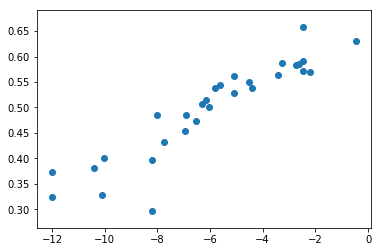

In [287]:
y = ds.WinPc
x = ds.DF
plt.scatter(x, y)
plt.show()

- display how team win percent is effected by the difference in defensemen quality (DD).

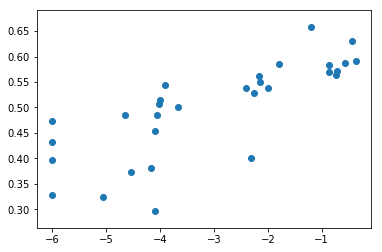

In [288]:
y = ds.WinPc
x = ds.DD
plt.scatter(x, y)
plt.show()

- display how mean goals for per team is effected by the difference in forwards quality (DF).

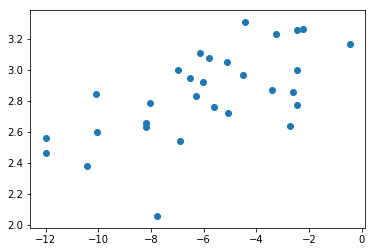

In [289]:
y = ds.meanGF
x = ds.DF
plt.scatter(x, y)
plt.show()

- display how mean goals against per team is effected by the difference in forwards quality (DF).

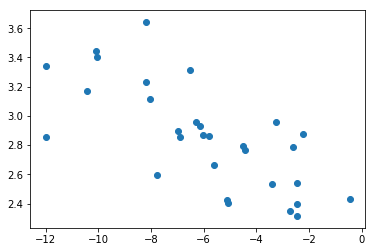

In [290]:
y = ds.meanGA
x = ds.DF
plt.scatter(x, y)
plt.show()

- display how mean goals for per team is effected by the difference in defensemen quality (DD).

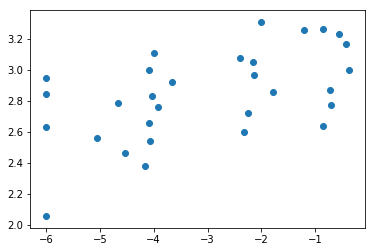

In [291]:
y = ds.meanGF
x = ds.DD
plt.scatter(x, y)
plt.show()

- display how mean goals against per team is effected by the difference in defensemen quality (DD).

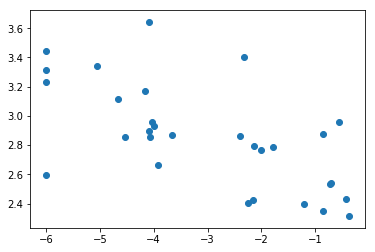

In [292]:
y = ds.meanGA
x = ds.DD
plt.scatter(x, y)
plt.show()

## season_game_level_analysis

- merge season game data (dg) and season game roster (dy).

In [293]:
dl = dg.merge(dy, on=['Season', 'GameNumber'], how='left')
dl.head()

,Season,GameNumber,VTeamCode,HTeamCode,VGF,HGF,GD,VGA,HGA,WinTeam,LossTeam,VF1,VF2,VD1,VD2,HF1,HF2,HD1,HD2
0,2010,20001,MTL,TOR,2,3,1,3,2,TOR,MTL,2.0,10.0,1.0,5.0,2.0,10.0,1.0,5.0
1,2010,20002,PHI,PIT,3,2,-1,2,3,PHI,PIT,5.0,7.0,2.0,4.0,5.0,7.0,3.0,3.0
2,2010,20003,CAR,MIN,4,3,-1,3,4,CAR,MIN,3.0,9.0,1.0,5.0,2.0,10.0,1.0,5.0
3,2010,20004,CHI,COL,3,4,1,4,3,COL,CHI,4.0,8.0,2.0,4.0,2.0,10.0,1.0,5.0
4,2010,20005,CGY,EDM,0,4,4,4,0,EDM,CGY,3.0,9.0,1.0,5.0,0.0,12.0,1.0,5.0


- determine if the home or away team won the game.

In [294]:
dl['WinTeam'] = dl.apply(lambda x: 'HOME' if x['GD'] > 0 else 'AWAY', axis=1)

- Calculate the difference between player quality per game for all positions with respect to home team ( Home Team - Visitor Team). There are 5 positions and 2 types of player quality. This will give us a total of 10 differenecs. 

In [295]:
dl.shape

(1230, 19)

- total of forwards and defensemen by team per game.

In [296]:
dl['VF'] = dl['VF1'] + dl['VF2']
dl['VD'] = dl['VD1'] + dl['VD2']
dl['HF'] = dl['HF1'] + dl['HF2']
dl['HD'] = dl['HD1'] + dl['HD2']

- total of forwards and defensemen per game.

In [297]:
dl['F'] = dl['VF'] + dl['HF']
dl['D'] = dl['VD'] + dl['HD']
dl.head()

,Season,GameNumber,VTeamCode,HTeamCode,VGF,HGF,GD,VGA,HGA,WinTeam,LossTeam,VF1,VF2,VD1,VD2,HF1,HF2,HD1,HD2,VF,VD,HF,HD,F,D
0,2010,20001,MTL,TOR,2,3,1,3,2,HOME,MTL,2.0,10.0,1.0,5.0,2.0,10.0,1.0,5.0,12.0,6.0,12.0,6.0,24.0,12.0
1,2010,20002,PHI,PIT,3,2,-1,2,3,AWAY,PIT,5.0,7.0,2.0,4.0,5.0,7.0,3.0,3.0,12.0,6.0,12.0,6.0,24.0,12.0
2,2010,20003,CAR,MIN,4,3,-1,3,4,AWAY,MIN,3.0,9.0,1.0,5.0,2.0,10.0,1.0,5.0,12.0,6.0,12.0,6.0,24.0,12.0
3,2010,20004,CHI,COL,3,4,1,4,3,HOME,CHI,4.0,8.0,2.0,4.0,2.0,10.0,1.0,5.0,12.0,6.0,12.0,6.0,24.0,12.0
4,2010,20005,CGY,EDM,0,4,4,4,0,HOME,CGY,3.0,9.0,1.0,5.0,0.0,12.0,1.0,5.0,12.0,6.0,12.0,6.0,24.0,12.0


- **keep games with 12 forwards and 6 defensemen per team.**

In [298]:
dl = dl[((dl['VF'] == 12) & (dl['VD'] == 6) & (dl['HF'] == 12) & (dl['HD'] == 6))]

In [299]:
dl.shape

(1015, 25)

In [300]:
dl['VF'].value_counts()

12.0    1015
Name: VF, dtype: int64

In [301]:
dl['VD'].value_counts()

6.0    1015
Name: VD, dtype: int64

In [302]:
dl['HF'].value_counts()

12.0    1015
Name: HF, dtype: int64

In [303]:
dl['HD'].value_counts()

6.0    1015
Name: HD, dtype: int64

### summary analysis

In [304]:
dl.describe()

,Season,GameNumber,VGF,HGF,GD,VGA,HGA,VF1,VF2,VD1,VD2,HF1,HF2,HD1,HD2,VF,VD,HF,HD,F,D
count,1015.0,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.0,1015.0,1015.0,1015.0,1015.0,1015.0
mean,2010.0,20622.621675,2.739901,2.941872,0.201970,2.941872,2.739901,2.825616,9.174384,1.401970,4.598030,3.266010,8.733990,1.599015,4.400985,12.0,6.0,12.0,6.0,24.0,12.0
std,0.0,352.180753,1.634000,1.716485,2.438513,1.716485,1.634000,1.527568,1.527568,0.946287,0.946287,1.590832,1.590832,1.012642,1.012642,0.0,0.0,0.0,0.0,0.0,0.0
min,2010.0,20001.000000,0.000000,0.000000,-8.000000,0.000000,0.000000,0.000000,6.000000,0.000000,3.000000,0.000000,6.000000,0.000000,3.000000,12.0,6.0,12.0,6.0,24.0,12.0
25%,2010.0,20319.500000,2.000000,2.000000,-1.000000,2.000000,2.000000,2.000000,8.000000,1.000000,4.000000,2.000000,7.000000,1.000000,4.000000,12.0,6.0,12.0,6.0,24.0,12.0
50%,2010.0,20628.000000,3.000000,3.000000,1.000000,3.000000,3.000000,3.000000,9.000000,1.000000,5.000000,3.000000,9.000000,2.000000,4.000000,12.0,6.0,12.0,6.0,24.0,12.0
75%,2010.0,20927.500000,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,10.000000,2.000000,5.000000,5.000000,10.000000,2.000000,5.000000,12.0,6.0,12.0,6.0,24.0,12.0
max,2010.0,21230.000000,10.000000,9.000000,7.000000,9.000000,10.000000,6.000000,12.000000,3.000000,6.000000,6.000000,12.000000,3.000000,6.000000,12.0,6.0,12.0,6.0,24.0,12.0


In [305]:
dl = dl[['Season', 'GameNumber', 'VTeamCode', 'HTeamCode', 'HGF', 'VGF', 'GD','WinTeam',
         'VF1', 'VF2', 'VD1', 'VD2', 
         'HF1', 'HF2', 'HD1', 'HD2']]

- determine if a game was won by the home or visitor team.
- compute the difference in quality of forwards and defensemen between home and visitor team per game (DF1, DF2, DD1, DD2). 

In [306]:
dl['HomeWin'] = dl.apply(lambda x: 1 if x['WinTeam']=='HOME' else 0, axis=1)
dl['DF1'] = dl['HF1'] - dl['VF1']
dl['DF2'] = dl['HF2'] - dl['VF2']
dl['DD1'] = dl['HD1'] - dl['VD1']
dl['DD2'] = dl['HD2'] - dl['VD2']

In [307]:
dl.groupby(['WinTeam'])['DF1', 'DF2', 'DD1', 'DD2'].describe()

DF1         DF2         DD1         DD2
WinTeam                                                      
AWAY    count  486.000000  486.000000  486.000000  486.000000
        mean     0.310700   -0.310700    0.131687   -0.131687
        std      2.183388    2.183388    1.378459    1.378459
        min     -5.000000   -6.000000   -3.000000   -3.000000
        25%     -1.000000   -2.000000   -1.000000   -1.000000
        50%      0.000000    0.000000    0.000000    0.000000
        75%      2.000000    1.000000    1.000000    1.000000
        max      6.000000    5.000000    3.000000    3.000000
HOME    count  529.000000  529.000000  529.000000  529.000000
        mean     0.559546   -0.559546    0.257089   -0.257089
        std      2.209816    2.209816    1.444055    1.444055
        min     -5.000000   -6.000000   -3.000000   -3.000000
        25%     -1.000000   -2.000000   -1.000000   -1.000000
        50%      1.000000   -1.000000    0.000000    0.000000
        75%      2.000000    1.000000    1.000000    1.000000
        max      6.000000    5.000000    3.000000    3.000000

### estimate roster model

- regress **home win** on the difference in number of home and visitor players by position and quality (DF1, DF2, DD1, DD2). Add a constant to the predictors and use OLS. The purpose is to deterimine the impact each roster position has on home team success.

In [308]:
y = dl['HomeWin']  
X = sm.add_constant(dl[['DF1', 'DD1', 'DF2', 'DD2']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HomeWin   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.635
Date:                Tue, 05 Dec 2017   Prob (F-statistic):              0.196
Time:                        22:51:20   Log-Likelihood:                -734.13
No. Observations:                1015   AIC:                             1474.
Df Residuals:                    1012   BIC:                             1489.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5155      0.016     32.242      0.000         0.484     0.547
DF1            0.0058      0.005      1.129      0.259        -0.004     0.016
DD1            0.0012      0.008      0.153      0.878        -0.015     0.017
DF2           -0.0058      0.005     -1.129      0.259        -0.016     0.004
DD2           -0.0012      0.008     -0.153      0.878        -0.017     0.015
==============================================================================
Omnibus:                        1.213   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.545   Jarque-Bera (JB):              167.003
Skew:                          -0.084   Prob(JB):                     5.44e-37
Kurtosis:                       1.020   Cond. No.                     1.00e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.27e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [309]:
result.params

const    0.515545
DF1      0.005848
DD1      0.001235
DF2     -0.005848
DD2     -0.001235
dtype: float64

- By increasing the differential of **elite** player quality in forwards and defense (home team – visitor team) by one unit, home win **increases** by 0.4 and 1 game respectfully.
- By increasing the differential of **secondary** player quality in forwards and defense (home team – visitor team) by one unit, home win **decreases** by 0.4 and 1 game respectfully.

- regress **home win** on the difference in number of elite home and visitor players by position (DF1, DD1). Add a constant to the predictors and use **OLS**. The purpose is to deterimine the impact each roster position has on home team success.

In [310]:
y = dl['HomeWin']  
X = sm.add_constant(dl[['DF1', 'DD1']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HomeWin   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.635
Date:                Tue, 05 Dec 2017   Prob (F-statistic):              0.196
Time:                        22:51:20   Log-Likelihood:                -734.13
No. Observations:                1015   AIC:                             1474.
Df Residuals:                    1012   BIC:                             1489.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5155      0.016     32.242      0.000         0.484     0.547
DF1            0.0117      0.010      1.129      0.259        -0.009     0.032
DD1            0.0025      0.016      0.153      0.878        -0.029     0.034
==============================================================================
Omnibus:                        1.213   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.545   Jarque-Bera (JB):              167.003
Skew:                          -0.084   Prob(JB):                     5.44e-37
Kurtosis:                       1.020   Cond. No.                         2.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **home win** on the difference in number of elite home and visitor players by position (DF1, DD1). Add a constant to the predictors and use **Logit**. The purpose is to deterimine the impact each roster position has on home team success.

In [311]:
y = dl['HomeWin']  
X = sm.add_constant(dl[['DF1', 'DD1']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.690637
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HomeWin   No. Observations:                 1015
Model:                          Logit   Df Residuals:                     1012
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                0.002329
Time:                        22:51:20   Log-Likelihood:                -701.00
converged:                       True   LL-Null:                       -702.63
                                        LLR p-value:                    0.1947
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0624      0.064      0.973      0.331        -0.063     0.188
DF1            0.0470      0.042      1.128      0.259        -0.035     0.129
DD1            0.0099      0.065      0.153      0.879        -0.117     0.137
==============================================================================
"""

- regress **home win** on the difference in number of secondary quality home and visitor players by position (DF2, DD2). Add a constant to the predictors and use **Logit**. The purpose is to deterimine the impact each roster position has on home team success.

In [312]:
y = dl['HomeWin']  
X = sm.add_constant(dl[['DF2', 'DD2']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.690637
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HomeWin   No. Observations:                 1015
Model:                          Logit   Df Residuals:                     1012
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                0.002329
Time:                        22:51:20   Log-Likelihood:                -701.00
converged:                       True   LL-Null:                       -702.63
                                        LLR p-value:                    0.1947
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0624      0.064      0.973      0.331        -0.063     0.188
DF2           -0.0470      0.042     -1.128      0.259        -0.129     0.035
DD2           -0.0099      0.065     -0.153      0.879        -0.137     0.117
==============================================================================
"""

- regress **goal differential** on the difference in number of home and visitor players by position and quality (DF1, DF2, DD1, DD2). Add a constant to the predictors and use OLS. The purpose is to deterimine the impact each roster position has on goal differential.

In [313]:
y = dl['GD']  
X = sm.add_constant(dl[['DF1', 'DD1', 'DF2', 'DD2']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.435
Date:                Tue, 05 Dec 2017   Prob (F-statistic):              0.239
Time:                        22:51:20   Log-Likelihood:                -2343.0
No. Observations:                1015   AIC:                             4692.
Df Residuals:                    1012   BIC:                             4707.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1787      0.078      2.291      0.022         0.026     0.332
DF1            0.0409      0.025      1.617      0.106        -0.009     0.090
DD1           -0.0324      0.039     -0.824      0.410        -0.110     0.045
DF2           -0.0409      0.025     -1.617      0.106        -0.090     0.009
DD2            0.0324      0.039      0.824      0.410        -0.045     0.110
==============================================================================
Omnibus:                        0.427   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.516
Skew:                           0.001   Prob(JB):                        0.773
Kurtosis:                       2.890   Cond. No.                     1.00e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.27e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## season_game_team_level_analysis

- use season game data (dg) and season game team roster (dx) to conduct season game team level analysis (dt).

In [314]:
dg.head()

,Season,GameNumber,VTeamCode,HTeamCode,VGF,HGF,GD,VGA,HGA,WinTeam,LossTeam
0,2010,20001,MTL,TOR,2,3,1,3,2,TOR,MTL
1,2010,20002,PHI,PIT,3,2,-1,2,3,PHI,PIT
2,2010,20003,CAR,MIN,4,3,-1,3,4,CAR,MIN
3,2010,20004,CHI,COL,3,4,1,4,3,COL,CHI
4,2010,20005,CGY,EDM,0,4,4,4,0,EDM,CGY


In [315]:
dt = dg.merge(dx, on=['Season', 'GameNumber'], how='left')
dt.head()

,Season,GameNumber,VTeamCode,HTeamCode,VGF,HGF,GD,VGA,HGA,WinTeam,LossTeam,TeamCode,RosterCount,D1,D2,F1,F2,MeanF1,MeanF2,MeanD1,MeanD2,A
0,2010,20001,MTL,TOR,2,3,1,3,2,TOR,MTL,MTL,18.0,1.0,5.0,2.0,10.0,3.191176,8.808824,1.044118,4.955882,1.0
1,2010,20001,MTL,TOR,2,3,1,3,2,TOR,MTL,TOR,18.0,1.0,5.0,2.0,10.0,1.985714,10.014286,0.671429,5.328571,NaN
2,2010,20002,PHI,PIT,3,2,-1,2,3,PHI,PIT,PHI,18.0,2.0,4.0,5.0,7.0,4.888889,7.111111,2.569444,3.430556,1.0
3,2010,20002,PHI,PIT,3,2,-1,2,3,PHI,PIT,PIT,18.0,3.0,3.0,5.0,7.0,4.295775,7.704225,2.633803,3.366197,NaN
4,2010,20003,CAR,MIN,4,3,-1,3,4,CAR,MIN,CAR,18.0,1.0,5.0,3.0,9.0,2.986842,9.013158,1.171053,4.828947,1.0


In [316]:
dt.shape

(2245, 22)

- Sum up goals for and against by team per game and find the goal differential (GD) per game. Assign a value of 1 to the team that won the game. 

In [317]:
dt['GD'] = dt.apply(lambda x: (x['HGF'] - x['VGF']) if x['HTeamCode']== x['TeamCode'] else (x['VGF'] - x['HGF']), 1)
dt['Win'] = dt.apply(lambda x: 1 if x['WinTeam']== x['TeamCode'] else 0, 1)
dt['GF'] = dt.apply(lambda x: x['HGF'] if x['HTeamCode']== x['TeamCode'] else x['VGF'], 1)
dt['GA'] = dt.apply(lambda x: x['HGF'] if x['HTeamCode']!= x['TeamCode'] else x['VGF'], 1)
dt.head()

,Season,GameNumber,VTeamCode,HTeamCode,VGF,HGF,GD,VGA,HGA,WinTeam,LossTeam,TeamCode,RosterCount,D1,D2,F1,F2,MeanF1,MeanF2,MeanD1,MeanD2,A,Win,GF,GA
0,2010,20001,MTL,TOR,2,3,-1,3,2,TOR,MTL,MTL,18.0,1.0,5.0,2.0,10.0,3.191176,8.808824,1.044118,4.955882,1.0,0,2,3
1,2010,20001,MTL,TOR,2,3,1,3,2,TOR,MTL,TOR,18.0,1.0,5.0,2.0,10.0,1.985714,10.014286,0.671429,5.328571,NaN,1,3,2
2,2010,20002,PHI,PIT,3,2,1,2,3,PHI,PIT,PHI,18.0,2.0,4.0,5.0,7.0,4.888889,7.111111,2.569444,3.430556,1.0,1,3,2
3,2010,20002,PHI,PIT,3,2,-1,2,3,PHI,PIT,PIT,18.0,3.0,3.0,5.0,7.0,4.295775,7.704225,2.633803,3.366197,NaN,0,2,3
4,2010,20003,CAR,MIN,4,3,1,3,4,CAR,MIN,CAR,18.0,1.0,5.0,3.0,9.0,2.986842,9.013158,1.171053,4.828947,1.0,1,4,3


- total of forwards and defensemen by team per game.

In [318]:
dt['F'] = dt['F1'] + dt['F2']
dt['D'] = dt['D1'] + dt['D2']

- display the difference of quality per position.

In [319]:
dt['DF'] = dt['F1'] - dt['F2']
dt['DD'] = dt['D1'] - dt['D2']

In [320]:
dt['F'].value_counts()

12.0    2030
Name: F, dtype: int64

In [321]:
dt['D'].value_counts()

6.0    2030
Name: D, dtype: int64

-**keep only games that have 12 forwards and 6 defensemen.**

In [322]:
dt = dt.groupby(['Season', 'GameNumber']).filter(lambda x: ((x['F'] == 12) & (x['D'] == 6)).all())

In [323]:
dt['F'].value_counts()

12.0    2030
Name: F, dtype: int64

In [324]:
dt['D'].value_counts()

6.0    2030
Name: D, dtype: int64

In [325]:
dt.shape

(2030, 29)

### summary analysis

In [326]:
dt.describe()

,Season,GameNumber,VGF,HGF,GD,VGA,HGA,RosterCount,D1,D2,F1,F2,MeanF1,MeanF2,MeanD1,MeanD2,A,Win,GF,GA,F,D,DF,DD
count,2030.0,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.0,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,1015.0,2030.000000,2030.000000,2030.000000,2030.0,2030.0,2030.000000,2030.000000
mean,2010.0,20622.621675,2.739901,2.941872,0.000000,2.941872,2.739901,18.0,1.500493,4.499507,3.045813,8.954187,3.045813,8.954187,1.500493,4.499507,1.0,0.500000,2.840887,2.840887,12.0,6.0,-5.908374,-2.999015
std,0.0,352.093955,1.633597,1.716062,2.446268,1.716062,1.633597,0.0,0.984728,0.984728,1.574617,1.574617,1.508459,1.508459,0.913683,0.913683,0.0,0.500123,1.678379,1.678379,0.0,0.0,3.149234,1.969456
min,2010.0,20001.000000,0.000000,0.000000,-8.000000,0.000000,0.000000,18.0,0.000000,3.000000,0.000000,6.000000,0.000000,6.230769,0.000000,3.184211,1.0,0.000000,0.000000,0.000000,12.0,6.0,-12.000000,-6.000000
25%,2010.0,20319.250000,2.000000,2.000000,-2.000000,2.000000,2.000000,18.0,1.000000,4.000000,2.000000,8.000000,1.985714,7.632353,0.915493,3.602740,1.0,0.000000,2.000000,2.000000,12.0,6.0,-8.000000,-4.000000
50%,2010.0,20628.000000,3.000000,3.000000,0.000000,3.000000,3.000000,18.0,1.000000,5.000000,3.000000,9.000000,3.092308,8.907692,1.171053,4.828947,1.0,0.500000,3.000000,3.000000,12.0,6.0,-6.000000,-4.000000
75%,2010.0,20927.750000,4.000000,4.000000,2.000000,4.000000,4.000000,18.0,2.000000,5.000000,4.000000,10.000000,4.367647,10.014286,2.397260,5.084507,1.0,1.000000,4.000000,4.000000,12.0,6.0,-4.000000,-2.000000
max,2010.0,21230.000000,10.000000,9.000000,8.000000,9.000000,10.000000,18.0,3.000000,6.000000,6.000000,12.000000,5.769231,12.000000,2.815789,6.000000,1.0,1.000000,10.000000,10.000000,12.0,6.0,0.000000,0.000000


In [327]:
dt.groupby(['Win'])['F1', 'F2', 'D1', 'D2'].describe()

F1           F2           D1           D2
Win                                                          
0   count  1015.000000  1015.000000  1015.000000  1015.000000
    mean      2.760591     9.239409     1.367488     4.632512
    std       1.587930     1.587930     0.977018     0.977018
    min       0.000000     6.000000     0.000000     3.000000
    25%       2.000000     8.000000     1.000000     4.000000
    50%       3.000000     9.000000     1.000000     5.000000
    75%       4.000000    10.000000     2.000000     5.000000
    max       6.000000    12.000000     3.000000     6.000000
1   count  1015.000000  1015.000000  1015.000000  1015.000000
    mean      3.331034     8.668966     1.633498     4.366502
    std       1.508939     1.508939     0.974862     0.974862
    min       0.000000     6.000000     0.000000     3.000000
    25%       2.000000     7.000000     1.000000     4.000000
    50%       3.000000     9.000000     2.000000     4.000000
    75%       5.000000    10.000000     2.000000     5.000000
    max       6.000000    12.000000     3.000000     6.000000

### estimate roster model

- regress **win** on the difference in number of players by position and quality per team. Add a constant to the predictors and use **OLS**. The purpose is to deterimine the impact each roster position has on home team success.

In [328]:
y = dt['Win']  
X = sm.add_constant(dt[['F1', 'D1', 'F2', 'D2']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     34.41
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           2.02e-15
Time:                        22:51:22   Log-Likelihood:                -1439.5
No. Observations:                2030   AIC:                             2885.
Df Residuals:                    2027   BIC:                             2902.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0074      0.000     28.719      0.000         0.007     0.008
F1             0.0725      0.006     11.958      0.000         0.061     0.084
D1             0.0232      0.008      2.803      0.005         0.007     0.039
F2             0.0159      0.005      3.541      0.000         0.007     0.025
D2             0.0210      0.008      2.579      0.010         0.005     0.037
==============================================================================
Omnibus:                        0.004   Durbin-Watson:                   2.968
Prob(Omnibus):                  0.998   Jarque-Bera (JB):              295.236
Skew:                          -0.004   Prob(JB):                     7.77e-65
Kurtosis:                       1.132   Cond. No.                     1.54e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.84e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [329]:
result.params

const    0.007366
F1       0.072453
D1       0.023225
F2       0.015941
D2       0.020972
dtype: float64

- regress **win** on the difference in number of players by position and quality per team. Add a constant to the predictors and use **Logit**. The purpose is to deterimine the impact each roster position has on home team success

In [332]:
y = dt['Win']  
X = sm.add_constant(dt[['F1', 'D1', 'F2', 'D2']] )
result = sm.Logit(y, X).fit()
result.summary()

         Current function value: 0.676525
         Iterations: 35


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:971: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2027
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.02398
Time:                        22:58:39   Log-Likelihood:                -1373.3
converged:                      False   LL-Null:                       -1407.1
                                        LLR p-value:                 2.215e-15
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0077        nan        nan        nan           nan       nan
F1             0.1624        nan        nan        nan           nan       nan
D1             0.0264   2.85e+05   9.25e-08      1.000     -5.59e+05  5.59e+05
F2            -0.0705        nan        nan        nan           nan       nan
D2             0.0196   2.85e+05   6.88e-08      1.000     -5.59e+05  5.59e+05
==============================================================================
"""

- regress **goal differential** on the difference in number of players by position and quality per team. Add a constant to the predictors and use **OLS**. The purpose is to deterimine the impact each roster position has on home team success

In [330]:
y = dt['GD']  
X = sm.add_constant(dt[['F1', 'D1', 'F2', 'D2']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     36.57
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           2.51e-16
Time:                        22:57:14   Log-Likelihood:                -4659.9
No. Observations:                2030   AIC:                             9326.
Df Residuals:                    2027   BIC:                             9343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0095      0.001      7.557      0.000         0.007     0.012
F1             0.1810      0.030      6.115      0.000         0.123     0.239
D1             0.0711      0.040      1.757      0.079        -0.008     0.151
F2            -0.0674      0.022     -3.062      0.002        -0.111    -0.024
D2            -0.0143      0.040     -0.360      0.719        -0.092     0.064
==============================================================================
Omnibus:                        0.145   Durbin-Watson:                   3.033
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.191
Skew:                           0.014   Prob(JB):                        0.909
Kurtosis:                       2.961   Cond. No.                     1.54e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.84e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- regress **win** on the differential of forwards and defensemen per team. Add a constant to the predictors and use **OLS**.

In [333]:
y = dt['Win']  
X = sm.add_constant(dt[['DF', 'DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     34.41
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           2.02e-15
Time:                        23:01:28   Log-Likelihood:                -1439.5
No. Observations:                2030   AIC:                             2885.
Df Residuals:                    2027   BIC:                             2902.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6703      0.023     28.719      0.000         0.625     0.716
DF             0.0283      0.005      5.529      0.000         0.018     0.038
DD             0.0011      0.008      0.138      0.890        -0.015     0.017
==============================================================================
Omnibus:                        0.004   Durbin-Watson:                   2.968
Prob(Omnibus):                  0.998   Jarque-Bera (JB):              295.236
Skew:                          -0.004   Prob(JB):                     7.77e-65
Kurtosis:                       1.132   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **win** on the differential of forwards and defensemen per team. Add a constant to the predictors and use **Logit**.

In [337]:
y = dt['Win']  
X = sm.add_constant(dt[['DF', 'DD']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.676525
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2027
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.02398
Time:                        23:07:01   Log-Likelihood:                -1373.3
converged:                       True   LL-Null:                       -1407.1
                                        LLR p-value:                 2.215e-15
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6973      0.098      7.138      0.000         0.506     0.889
DF             0.1165      0.021      5.426      0.000         0.074     0.159
DD             0.0034      0.034      0.100      0.920        -0.063     0.070
==============================================================================
"""

- regress **win** on the differential of forwards per team. Add a constant to the predictors and use **OLS**.

In [338]:
y = dt['Win']  
X = sm.add_constant(dt[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     68.83
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           1.93e-16
Time:                        23:07:02   Log-Likelihood:                -1439.5
No. Observations:                2030   AIC:                             2883.
Df Residuals:                    2028   BIC:                             2894.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6700      0.023     28.856      0.000         0.624     0.716
DF             0.0288      0.003      8.297      0.000         0.022     0.036
==============================================================================
Omnibus:                        0.005   Durbin-Watson:                   2.968
Prob(Omnibus):                  0.998   Jarque-Bera (JB):              295.254
Skew:                          -0.004   Prob(JB):                     7.70e-65
Kurtosis:                       1.132   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **win** on the differential of forwards per team. Add a constant to the predictors and use **Logit**.

In [339]:
y = dt['Win']  
X = sm.add_constant(dt[['DF']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.676527
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2028
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.02398
Time:                        23:07:06   Log-Likelihood:                -1373.4
converged:                       True   LL-Null:                       -1407.1
                                        LLR p-value:                 2.132e-16
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6964      0.097      7.160      0.000         0.506     0.887
DF             0.1180      0.015      8.061      0.000         0.089     0.147
==============================================================================
"""

- regress **win** on the differential of defensemen per team. Add a constant to the predictors and use **OLS**.

In [340]:
y = dt['Win']  
X = sm.add_constant(dt[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     37.70
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           9.88e-10
Time:                        23:07:06   Log-Likelihood:                -1454.7
No. Observations:                2030   AIC:                             2913.
Df Residuals:                    2028   BIC:                             2925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6029      0.020     30.077      0.000         0.564     0.642
DD             0.0343      0.006      6.140      0.000         0.023     0.045
==============================================================================
Omnibus:                        0.000   Durbin-Watson:                   2.983
Prob(Omnibus):                  1.000   Jarque-Bera (JB):              313.929
Skew:                          -0.000   Prob(JB):                     6.78e-69
Kurtosis:                       1.073   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **win** on the differential of defensemen per team. Add a constant to the predictors and use **Logit**.

In [341]:
y = dt['Win']  
X = sm.add_constant(dt[['DD']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.683965
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2028
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                 0.01325
Time:                        23:07:21   Log-Likelihood:                -1388.4
converged:                       True   LL-Null:                       -1407.1
                                        LLR p-value:                 1.024e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4167      0.082      5.070      0.000         0.256     0.578
DD             0.1389      0.023      6.050      0.000         0.094     0.184
==============================================================================
"""

- regress **goal differential** on the differential of forwards and defensemen per team. Add a constant to the predictors and use **OLS**.

In [342]:
y = dt['GD']
X = sm.add_constant(dt[['DF', 'DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     36.57
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           2.51e-16
Time:                        23:09:43   Log-Likelihood:                -4659.9
No. Observations:                2030   AIC:                             9326.
Df Residuals:                    2027   BIC:                             9343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8619      0.114      7.557      0.000         0.638     1.086
DF             0.1242      0.025      4.973      0.000         0.075     0.173
DD             0.0427      0.040      1.070      0.285        -0.036     0.121
==============================================================================
Omnibus:                        0.145   Durbin-Watson:                   3.033
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.191
Skew:                           0.014   Prob(JB):                        0.909
Kurtosis:                       2.961   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **goal differential** on the differential of forwards per team. Add a constant to the predictors and use **OLS**.

In [343]:
y = dt['GD']  
X = sm.add_constant(dt[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     71.98
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           4.12e-17
Time:                        23:11:16   Log-Likelihood:                -4660.5
No. Observations:                2030   AIC:                             9325.
Df Residuals:                    2028   BIC:                             9336.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8497      0.113      7.488      0.000         0.627     1.072
DF             0.1438      0.017      8.484      0.000         0.111     0.177
==============================================================================
Omnibus:                        0.132   Durbin-Watson:                   3.034
Prob(Omnibus):                  0.936   Jarque-Bera (JB):                0.174
Skew:                           0.014   Prob(JB):                        0.917
Kurtosis:                       2.964   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **goal differential** on the differential of defensemen per team. Add a constant to the predictors and use **OLS**.

In [344]:
y = dt['GD']  
X = sm.add_constant(dt[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     47.84
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           6.17e-12
Time:                        23:11:17   Log-Likelihood:                -4672.2
No. Observations:                2030   AIC:                             9348.
Df Residuals:                    2028   BIC:                             9360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5655      0.098      5.782      0.000         0.374     0.757
DD             0.1886      0.027      6.917      0.000         0.135     0.242
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   3.045
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.526
Skew:                           0.006   Prob(JB):                        0.769
Kurtosis:                       2.922   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **goals for ** on the differential of forwards per team. Add a constant to the predictors and use **OLS**.

In [346]:
y = dt['GF']  
X = sm.add_constant(dt[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GF   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     26.57
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           2.79e-07
Time:                        23:14:11   Log-Likelihood:                -3917.9
No. Observations:                2030   AIC:                             7840.
Df Residuals:                    2028   BIC:                             7851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.1990      0.079     40.639      0.000         3.045     3.353
DF             0.0606      0.012      5.155      0.000         0.038     0.084
==============================================================================
Omnibus:                       53.791   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.462
Skew:                           0.408   Prob(JB):                     3.33e-13
Kurtosis:                       3.109   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **goals for** on the differential of defensemen per team. Add a constant to the predictors and use **OLS**.

In [347]:
y = dt['GF']  
X = sm.add_constant(dt[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     18.71
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           1.59e-05
Time:                        23:14:19   Log-Likelihood:                -3921.8
No. Observations:                2030   AIC:                             7848.
Df Residuals:                    2028   BIC:                             7859.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.0853      0.068     45.653      0.000         2.953     3.218
DD             0.0815      0.019      4.326      0.000         0.045     0.118
==============================================================================
Omnibus:                       52.016   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.484
Skew:                           0.403   Prob(JB):                     8.95e-13
Kurtosis:                       3.075   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **goals against ** on the differential of forwards per team. Add a constant to the predictors and use **OLS**.

In [348]:
y = dt['GA']  
X = sm.add_constant(dt[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GA   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     50.67
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           1.51e-12
Time:                        23:14:29   Log-Likelihood:                -3906.1
No. Observations:                2030   AIC:                             7816.
Df Residuals:                    2028   BIC:                             7827.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.3493      0.078     30.019      0.000         2.196     2.503
DF            -0.0832      0.012     -7.118      0.000        -0.106    -0.060
==============================================================================
Omnibus:                       53.898   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.563
Skew:                           0.407   Prob(JB):                     3.16e-13
Kurtosis:                       3.128   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- regress **goals against** on the differential of defensemen per team. Add a constant to the predictors and use **OLS**.

In [349]:
y = dt['GA']  
X = sm.add_constant(dt[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GA   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     32.53
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           1.35e-08
Time:                        23:14:38   Log-Likelihood:                -3915.0
No. Observations:                2030   AIC:                             7834.
Df Residuals:                    2028   BIC:                             7845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.5198      0.067     37.411      0.000         2.388     2.652
DD            -0.1071      0.019     -5.703      0.000        -0.144    -0.070
==============================================================================
Omnibus:                       52.140   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.546
Skew:                           0.400   Prob(JB):                     8.68e-13
Kurtosis:                       3.127   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""